In [ ]:
%run PNe_fitting

In [1]:
gal_name = "FCC219"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
#from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
#from ipywidgets import FloatProgress
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import MUSE_3D_residual, PNe_spectrum_extractor, PNextractor, PSF_residuals, data_cube_y_x
import yaml
import sep
from photutils import CircularAperture

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data
hdulist = fits.open(gal_name+"_data/"+gal_name+"center_residuals_list_long.fits")

hdr = hdulist[0].header

#y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))

wavelength = np.exp(hdulist[1].data) # np.load(gal_name+"_data/wavelength.npy")

n_pixels= 9
c = 299792458.0

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

In [4]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D", "Chi^2", "Include"))
#PNe_df["Include"] = 
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D", "Chi^2", "Include"))
#PNe_df["Include"] = 
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")

def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs(np.std(extract_data[p], 1))
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
#error_cube = np.ones_like(error_cube)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
#obj_error_cube = np.ones_like(error_cube)

In [30]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

D = galaxy_data["Distance"]

z = galaxy_data["z"]

PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, em_dict=None, vary_state=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.01, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=(n_pixels/2.), min=0.01, max=n_pixels)
    PNe_multi_params.add("y_0", value=(n_pixels/2.), min=0.01, max=n_pixels)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_state)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_state)   
    PNe_multi_params.add("Gauss_bkg",  value=0.00001, vary=True)
    PNe_multi_params.add("Gauss_grad", value=0.00001, vary=True)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))
fit_FWHM = np.zeros(len(x_PNe))
fit_beta = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))


def log_10(x):
    return np.log10(x)

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        useful_stuff = []
        #run minimizer fitting routine
        multi_fit_results   = minimize(MUSE_3D_residual, PNe_multi_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num] = useful_stuff[1][0]
        F_xy_list[PNe_num] = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        emission_amp_list[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        fit_FWHM[PNe_num]   = multi_fit_results.params["M_FWHM"]
        fit_beta[PNe_num]   = multi_fit_results.params["beta"]
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.
    
    PNe_df["FWHM"] = fit_FWHM
    PNe_df["beta"] = fit_beta
    
    PNe_df["Chi^2"] = chi_2_r
    
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
    
    PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,3] # store OIII/Hb ratio
    
    PNe_df["[OIII]/Ha"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store OIII/Ha ratio
    
    PNe_df["[OIII]/Ha+[NII]"] = PNe_df["[OIII] Flux"] / (total_Flux[:,2] + total_Flux[:,4] + total_Flux[:,5])
    
    PNe_df["Ha/Hb"] = total_Flux[:,2] / total_Flux[:,3]
    
    def log_10(x):
        return np.log10(x)
    
    PNe_df["m 5007"] = -2.5 * PNe_df["[OIII] Flux"].apply(log_10) - 13.74
    dM =  5. * np.log10(D) + 25.
    PNe_df["M 5007"] = PNe_df["m 5007"] - dM
    
    Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.47) -25.) / 5.)
    print("Distance Estimate from PNLF: ", Dist_est, "Mpc")
    
    #dM =  5. * np.log10(Dist_est) + 25.   
    #PNe_df["M 5007"] = PNe_df["m 5007"] - dM


In [26]:
dM =  5. * np.log10(17.72) + 25.
print(dM)

31.24231858775516


Running fitter
Distance Estimate from PNLF:  15.31822526837249 Mpc


,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux,[OIII]/Hb,[OIII]/Ha,[OIII]/Ha+[NII],Ha/Hb
32,32,NaN,NaN,17.437538,27.100793,-4.425964,NaN,18.495203,NaN,0.777739,NaN,4.06,3.41,4.609808e-17,22.335056,4.68954,3.545235,4.762739


(array([ 1.,  1.,  7.,  9., 12.,  8.,  3.,  6.,  8.,  4.]),
 array([26.45604226, 26.66493682, 26.87383138, 27.08272595, 27.29162051,
        27.50051507, 27.70940963, 27.91830419, 28.12719876, 28.33609332,
        28.54498788]),
 <a list of 10 Patch objects>)

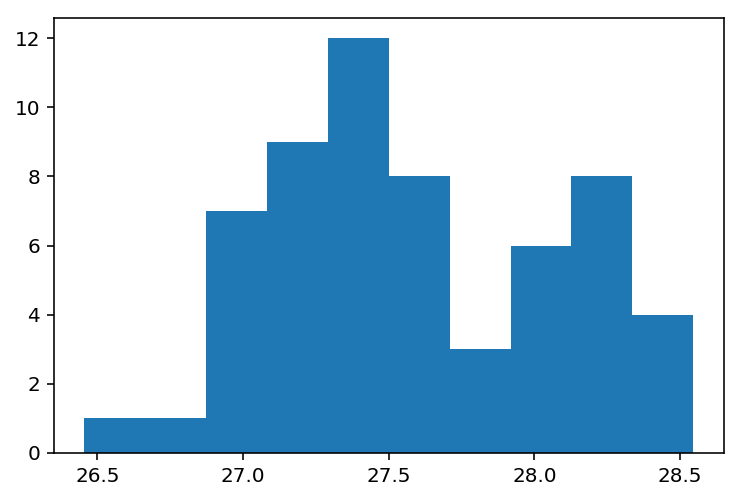

In [31]:
print("Running fitter")
gen_params(wave=5007.*(1+z), FWHM=4.06, beta=3.41, em_dict=emission_dict, vary_state=False)
run_minimiser(PNe_multi_params)
display(PNe_df.loc[PNe_df["PNe number"]==32])
plt.hist(PNe_df["m 5007"])

In [29]:
total_Flux[32][2]/total_Flux[32][3]

4.762738761121247

In [10]:
PNe_df.loc[[28, 32, 50, 51, 53]]

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux,[OIII]/Hb,[OIII]/Ha,[OIII]/Ha+[NII]
28,28,NaN,NaN,-346.221806,27.646914,-3.879843,NaN,10.544601,NaN,0.721399,NaN,4.06,3.41,2.787626e-17,4.540390,3.0,2.875167
32,32,NaN,NaN,17.437538,27.100793,-4.425964,NaN,18.495203,NaN,0.777739,NaN,4.06,3.41,4.609808e-17,4.689540,3.0,2.516202
50,50,NaN,NaN,-355.049207,27.390765,-4.135992,NaN,13.937747,NaN,0.703649,NaN,4.06,3.41,3.529344e-17,11.510659,3.0,2.955566
51,51,NaN,NaN,50.004898,28.105795,-3.420962,NaN,7.251712,NaN,0.727704,NaN,4.06,3.41,1.826763e-17,4.472849,3.0,2.324772
53,53,NaN,NaN,17.921436,27.414462,-4.112295,NaN,14.839499,NaN,0.735583,NaN,4.06,3.41,3.453149e-17,5.295744,3.0,2.225005


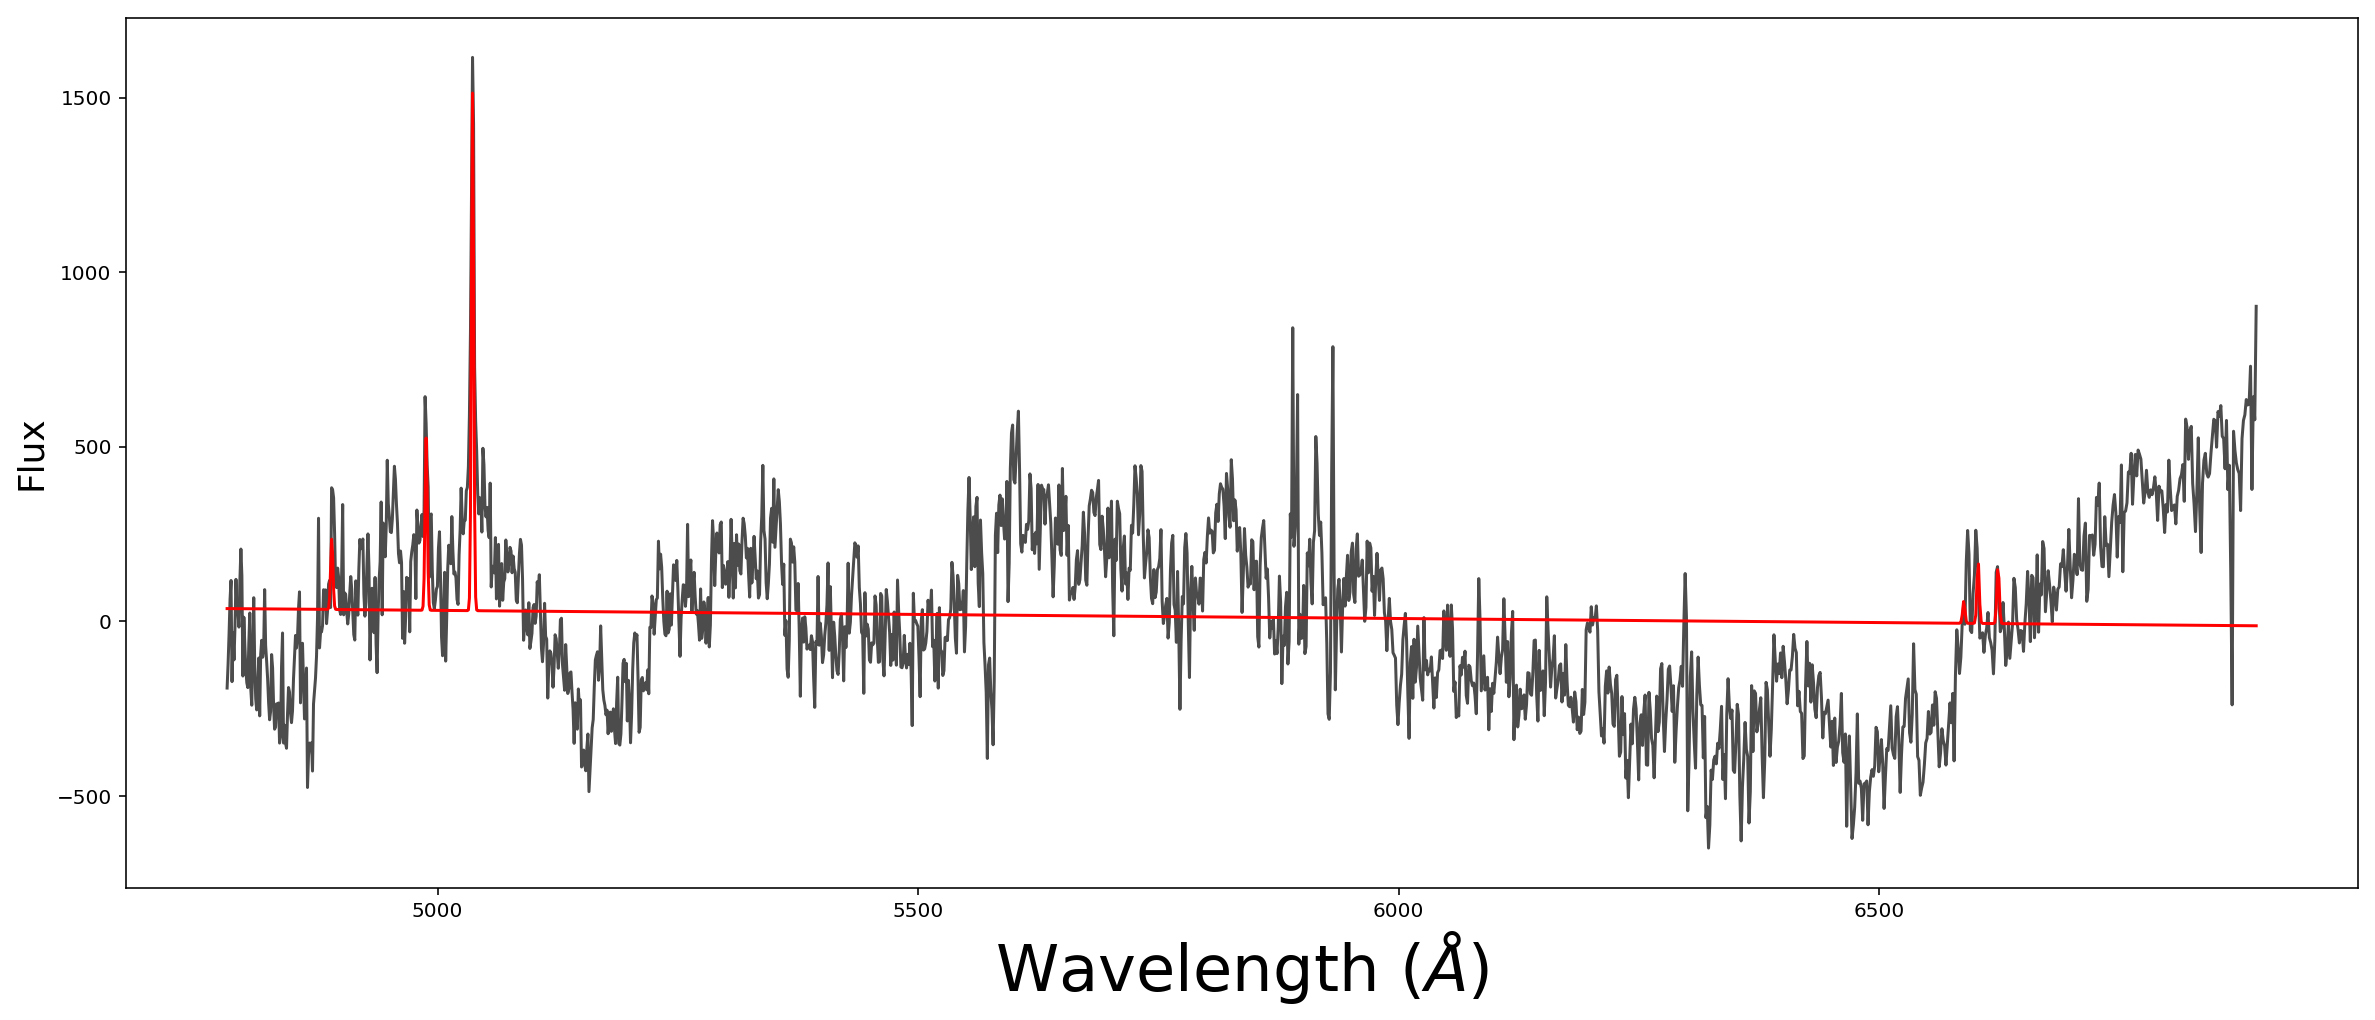

In [10]:
p = 20
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);

Running fitter
Distance Estimate from PNLF:  16.049682645941306 Mpc


,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux
32,32,NaN,NaN,16.651848,27.059039,-4.467717,NaN,15.293446,NaN,1.048213,NaN,4.06,2.15,4.790538e-17


(array([ 2., 11., 19.,  9., 10.,  7.,  0.,  0.,  0.,  1.]),
 array([26.55733225, 26.89482116, 27.23231007, 27.56979899, 27.9072879 ,
        28.24477681, 28.58226573, 28.91975464, 29.25724356, 29.59473247,
        29.93222138]),
 <a list of 10 Patch objects>)

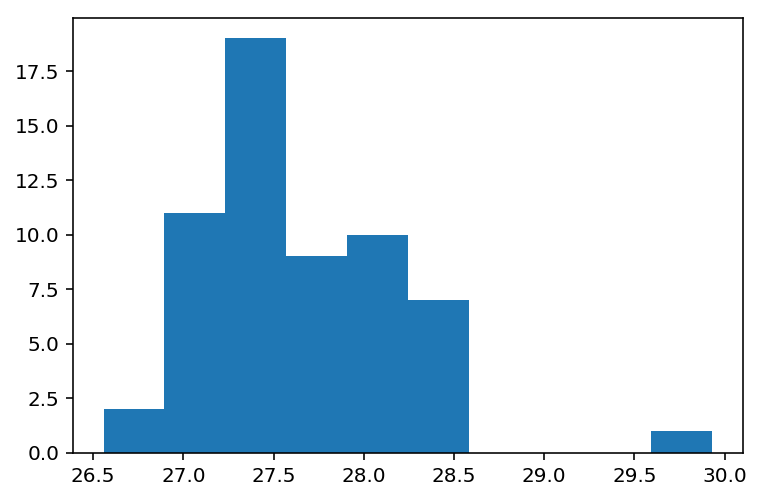

In [18]:
print("Running fitter")
gen_params(wave=5007.*(1+z), FWHM=4.06, beta=2.15, em_dict=emission_dict, vary_state=False)
run_minimiser(PNe_multi_params)
display(PNe_df.loc[PNe_df["PNe number"]==32])
plt.hist(PNe_df["m 5007"])

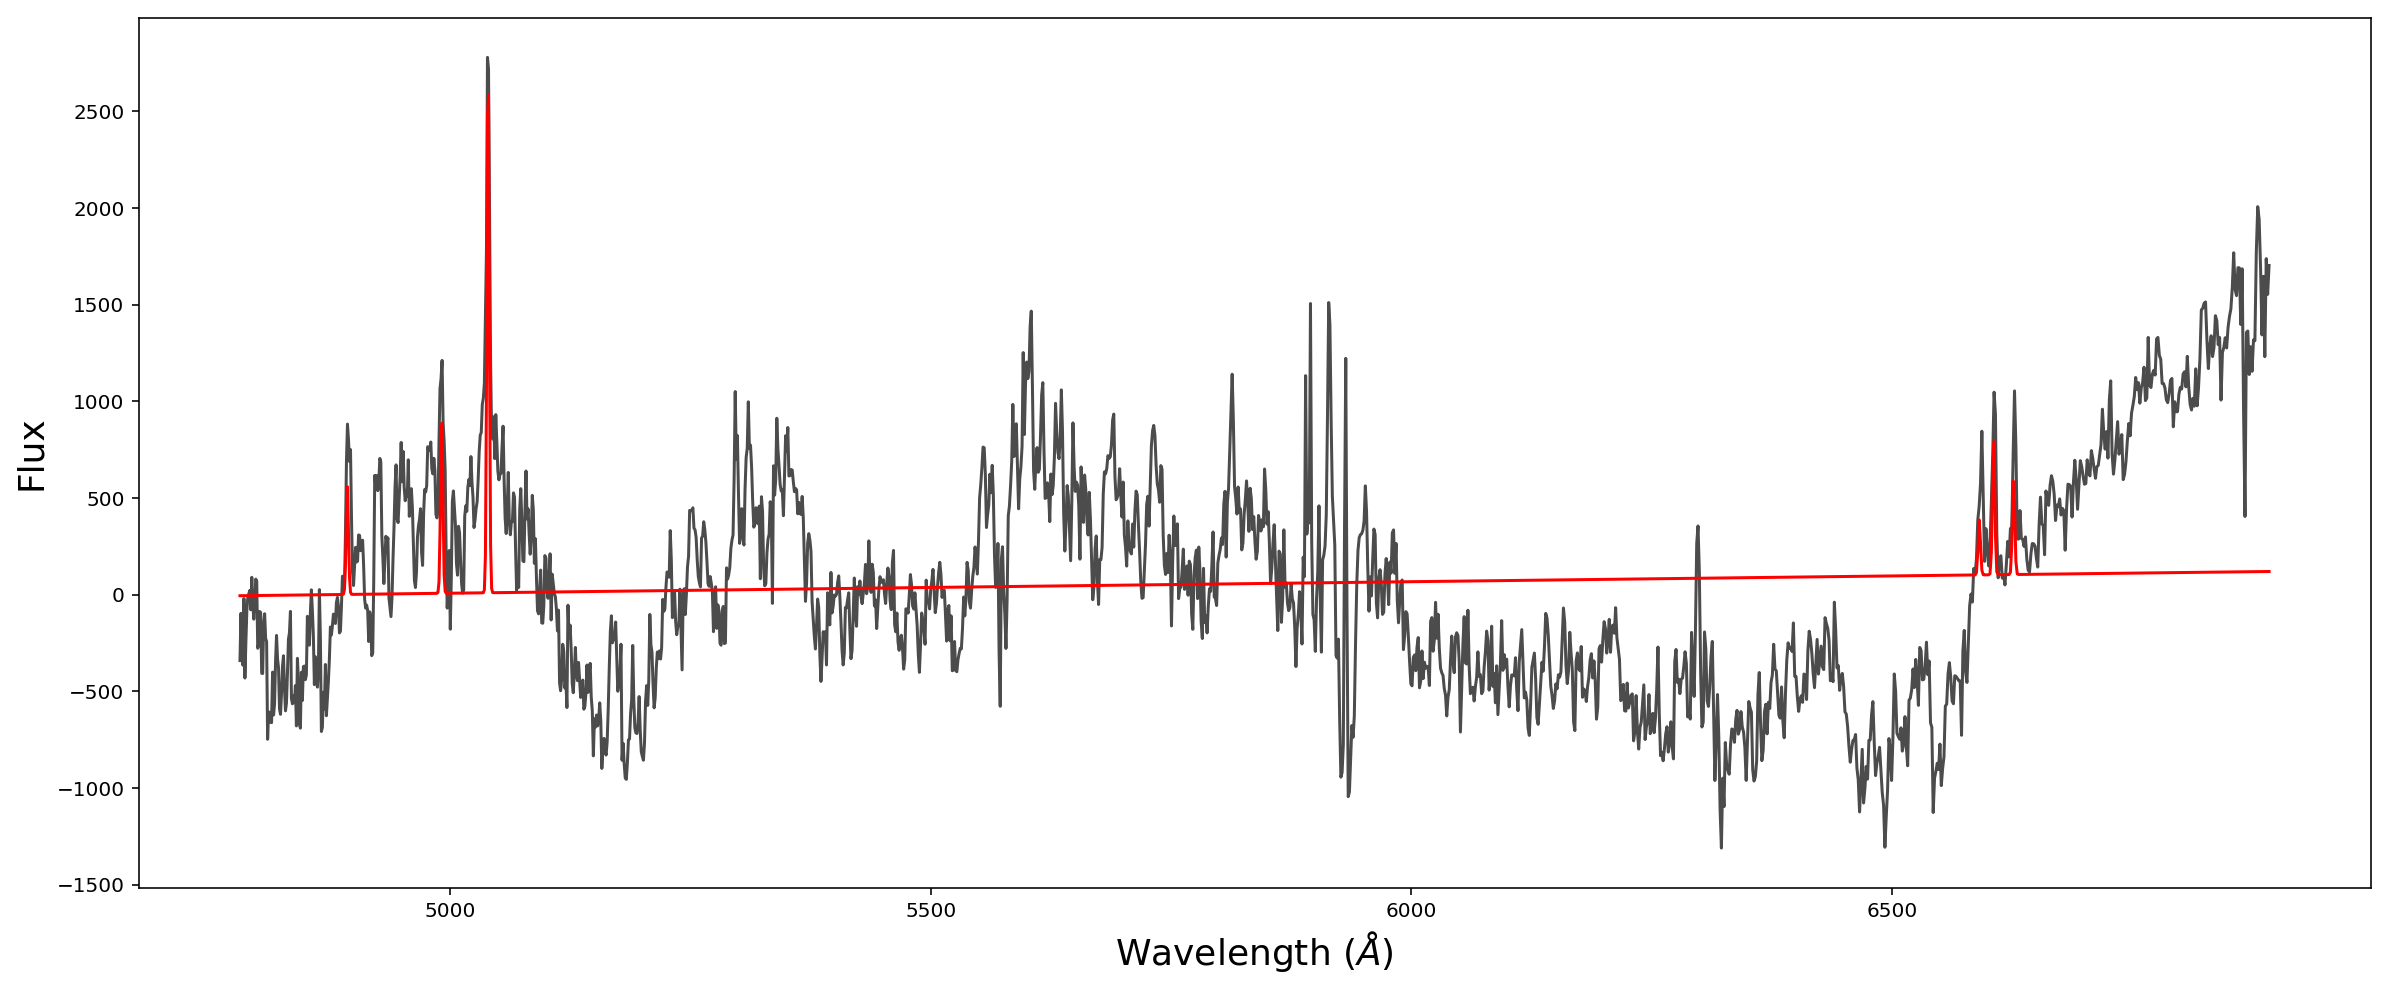

In [17]:
p = 1
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=18)
plt.ylabel("Flux", fontsize=18);

In [20]:
((np.abs(27.109089 - 27.059039)/27.109089)) *100

0.18462442614726882

In [16]:
PNe_df.nsmallest(10,"m 5007")

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux,[OIII]/Hb,[OIII]/Ha,[OIII]/Ha+[NII]
1,1,NaN,NaN,-20.202064,26.456042,-5.070715,NaN,9.579853,NaN,0.969449,NaN,4.06,3.41,8.348013e-17,3.692950,3.0,1.565924
0,0,NaN,NaN,-120.397146,26.864047,-4.662710,NaN,13.077387,NaN,0.807352,NaN,4.06,3.41,5.732990e-17,5.520490,3.0,1.998084
13,13,NaN,NaN,-131.485887,26.874088,-4.652669,NaN,6.995331,NaN,1.014444,NaN,4.06,3.41,5.680215e-17,8.836566,3.0,1.860111
16,16,NaN,NaN,-141.319388,26.951390,-4.575367,NaN,7.736948,NaN,0.970722,NaN,4.06,3.41,5.289860e-17,5.667507,3.0,1.513438
18,18,NaN,NaN,-27.929356,26.980685,-4.546071,NaN,7.006161,NaN,0.953121,NaN,4.06,3.41,5.149035e-17,10886.375556,3.0,1.798522
19,19,NaN,NaN,-261.648536,27.002094,-4.524663,NaN,7.160309,NaN,0.978403,NaN,4.06,3.41,5.048501e-17,7.146437,3.0,1.831181
7,7,NaN,NaN,168.134973,27.011703,-4.515054,NaN,6.162864,NaN,1.022455,NaN,4.06,3.41,5.004019e-17,12.640995,3.0,1.433329
5,5,NaN,NaN,-22.365733,27.017519,-4.509238,NaN,7.602226,NaN,0.898376,NaN,4.06,3.41,4.977284e-17,4.811476,3.0,1.894845
2,2,NaN,NaN,-38.405752,27.021612,-4.505145,NaN,6.904911,NaN,0.953772,NaN,4.06,3.41,4.958556e-17,3.952607,3.0,1.262221
32,32,NaN,NaN,17.437538,27.100793,-4.425964,NaN,18.495203,NaN,0.777739,NaN,4.06,3.41,4.609808e-17,4.689540,3.0,2.516202


# Load in data and plot FOV

In [22]:
x_data, y_data

(497, 812)

In [5]:
# Pull out the 1D flux data from 1D fits to do radial comparison


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

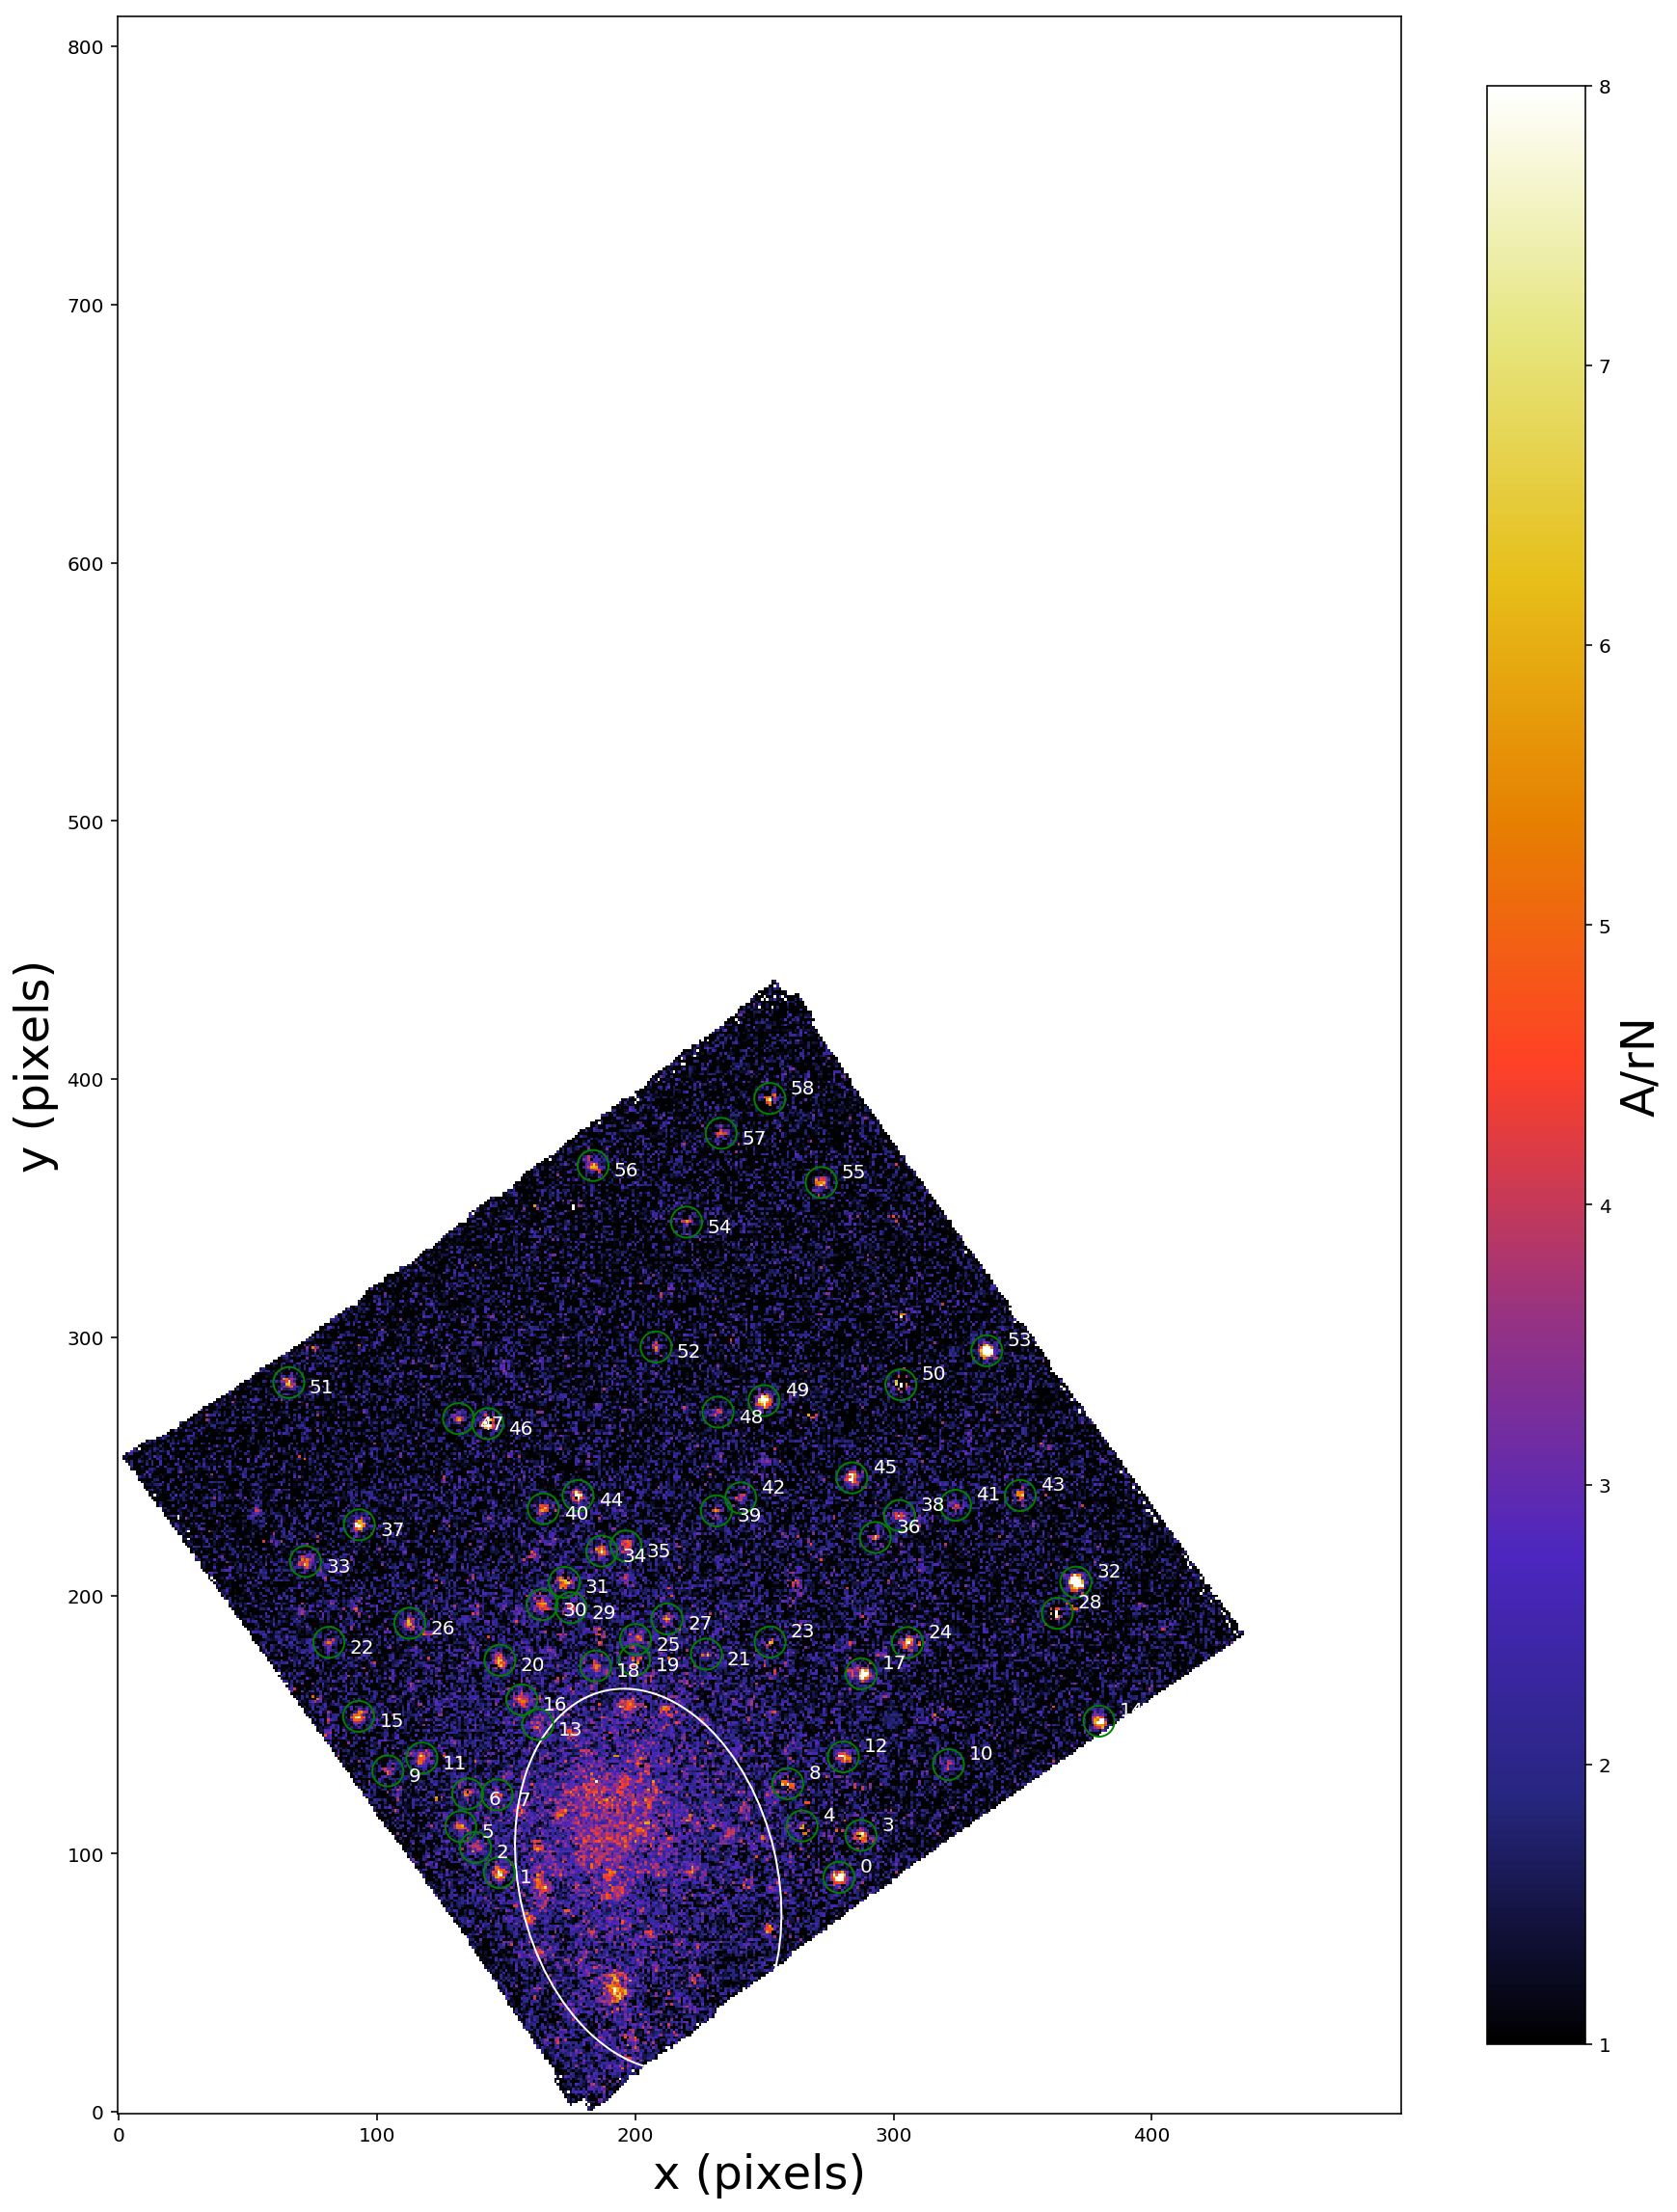

In [6]:

plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=24)

plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
#circ_r = plt.Circle((195,100), 45, color="white", fill=False)
#ax.add_artist(circ_r)
elip_gal = Ellipse((205, 90), 150, 100, angle=1.8*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="green", fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+8, item[1]+2), color="white", size=10)

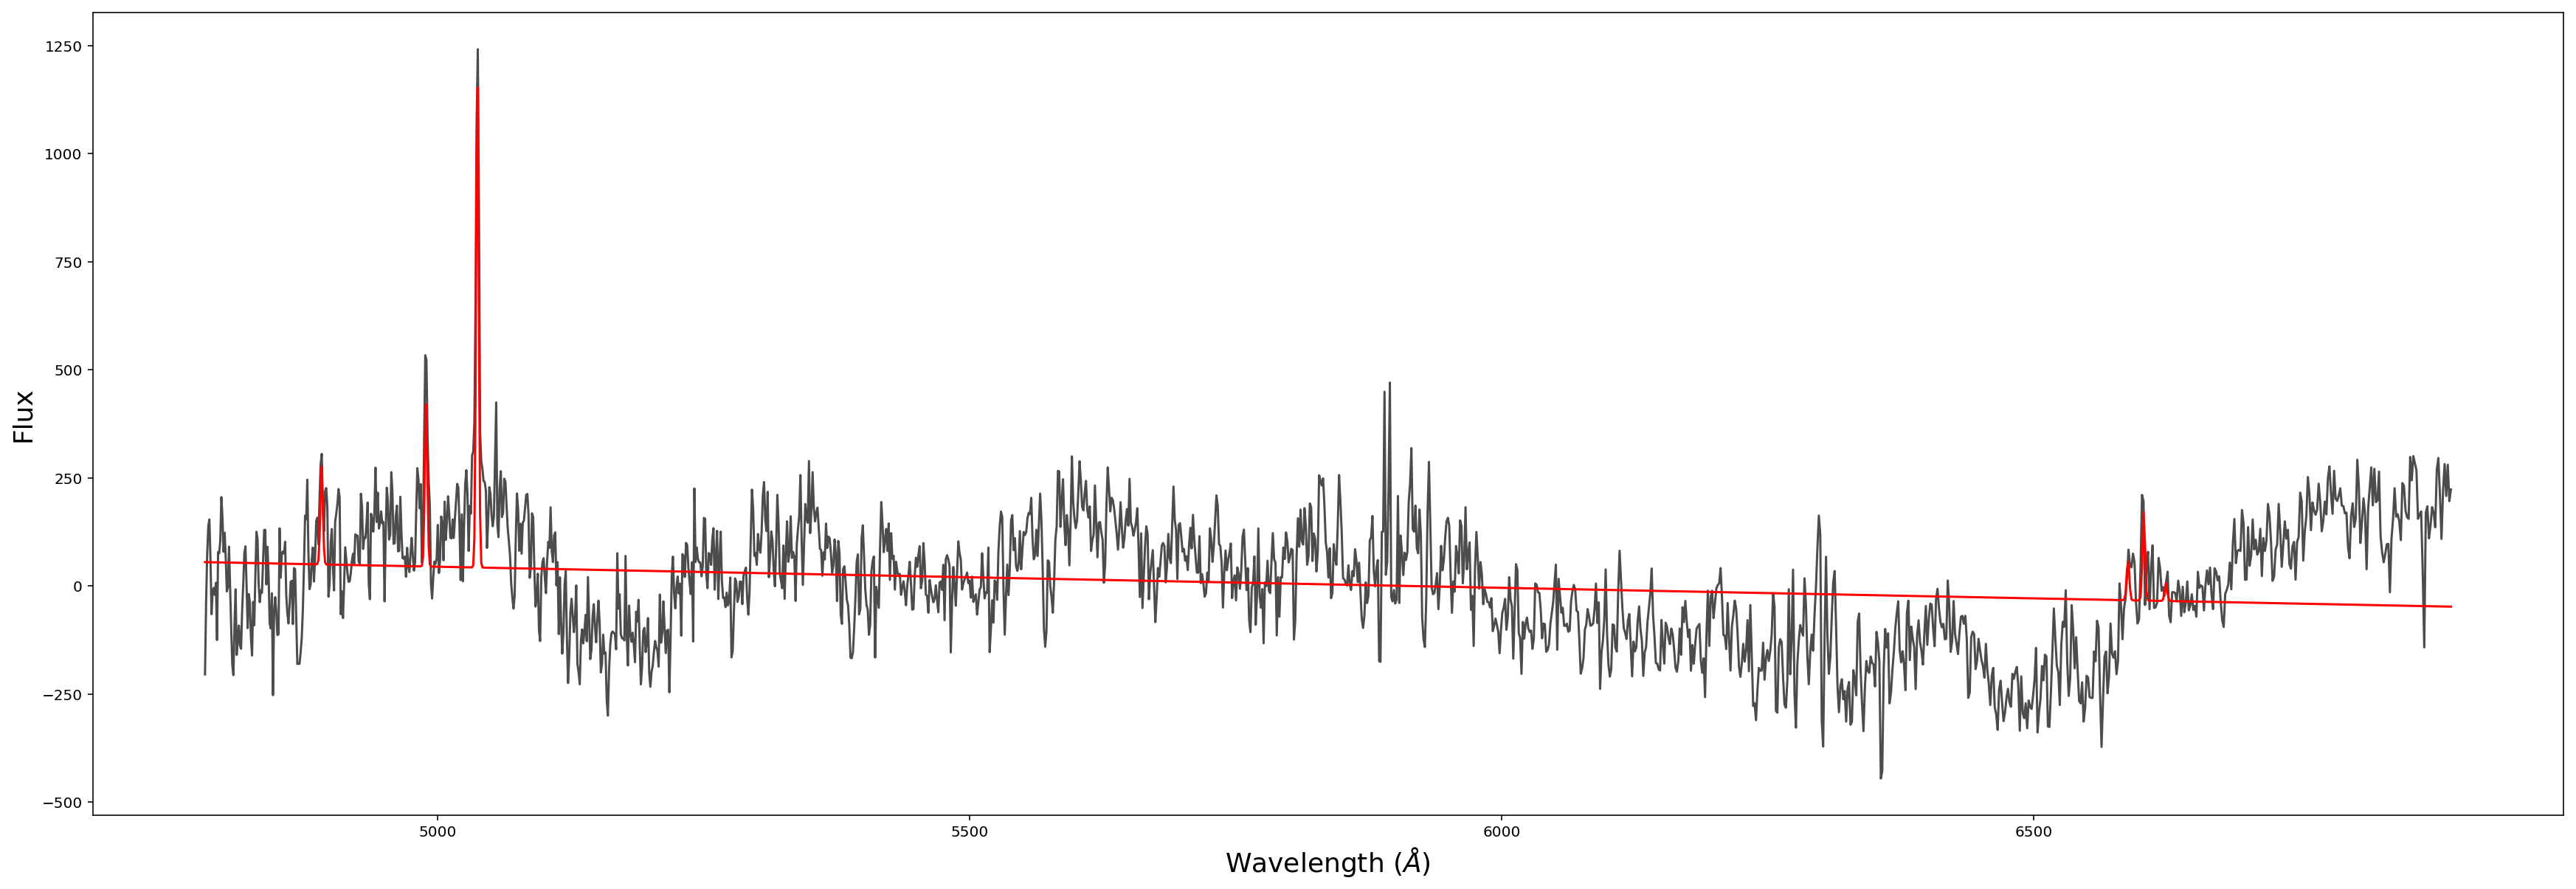

In [18]:
p =15
plt.figure(figsize=(30,10))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=18)
plt.ylabel("Flux", fontsize=18);

# SEP

59


<Figure size 1440x1440 with 0 Axes>

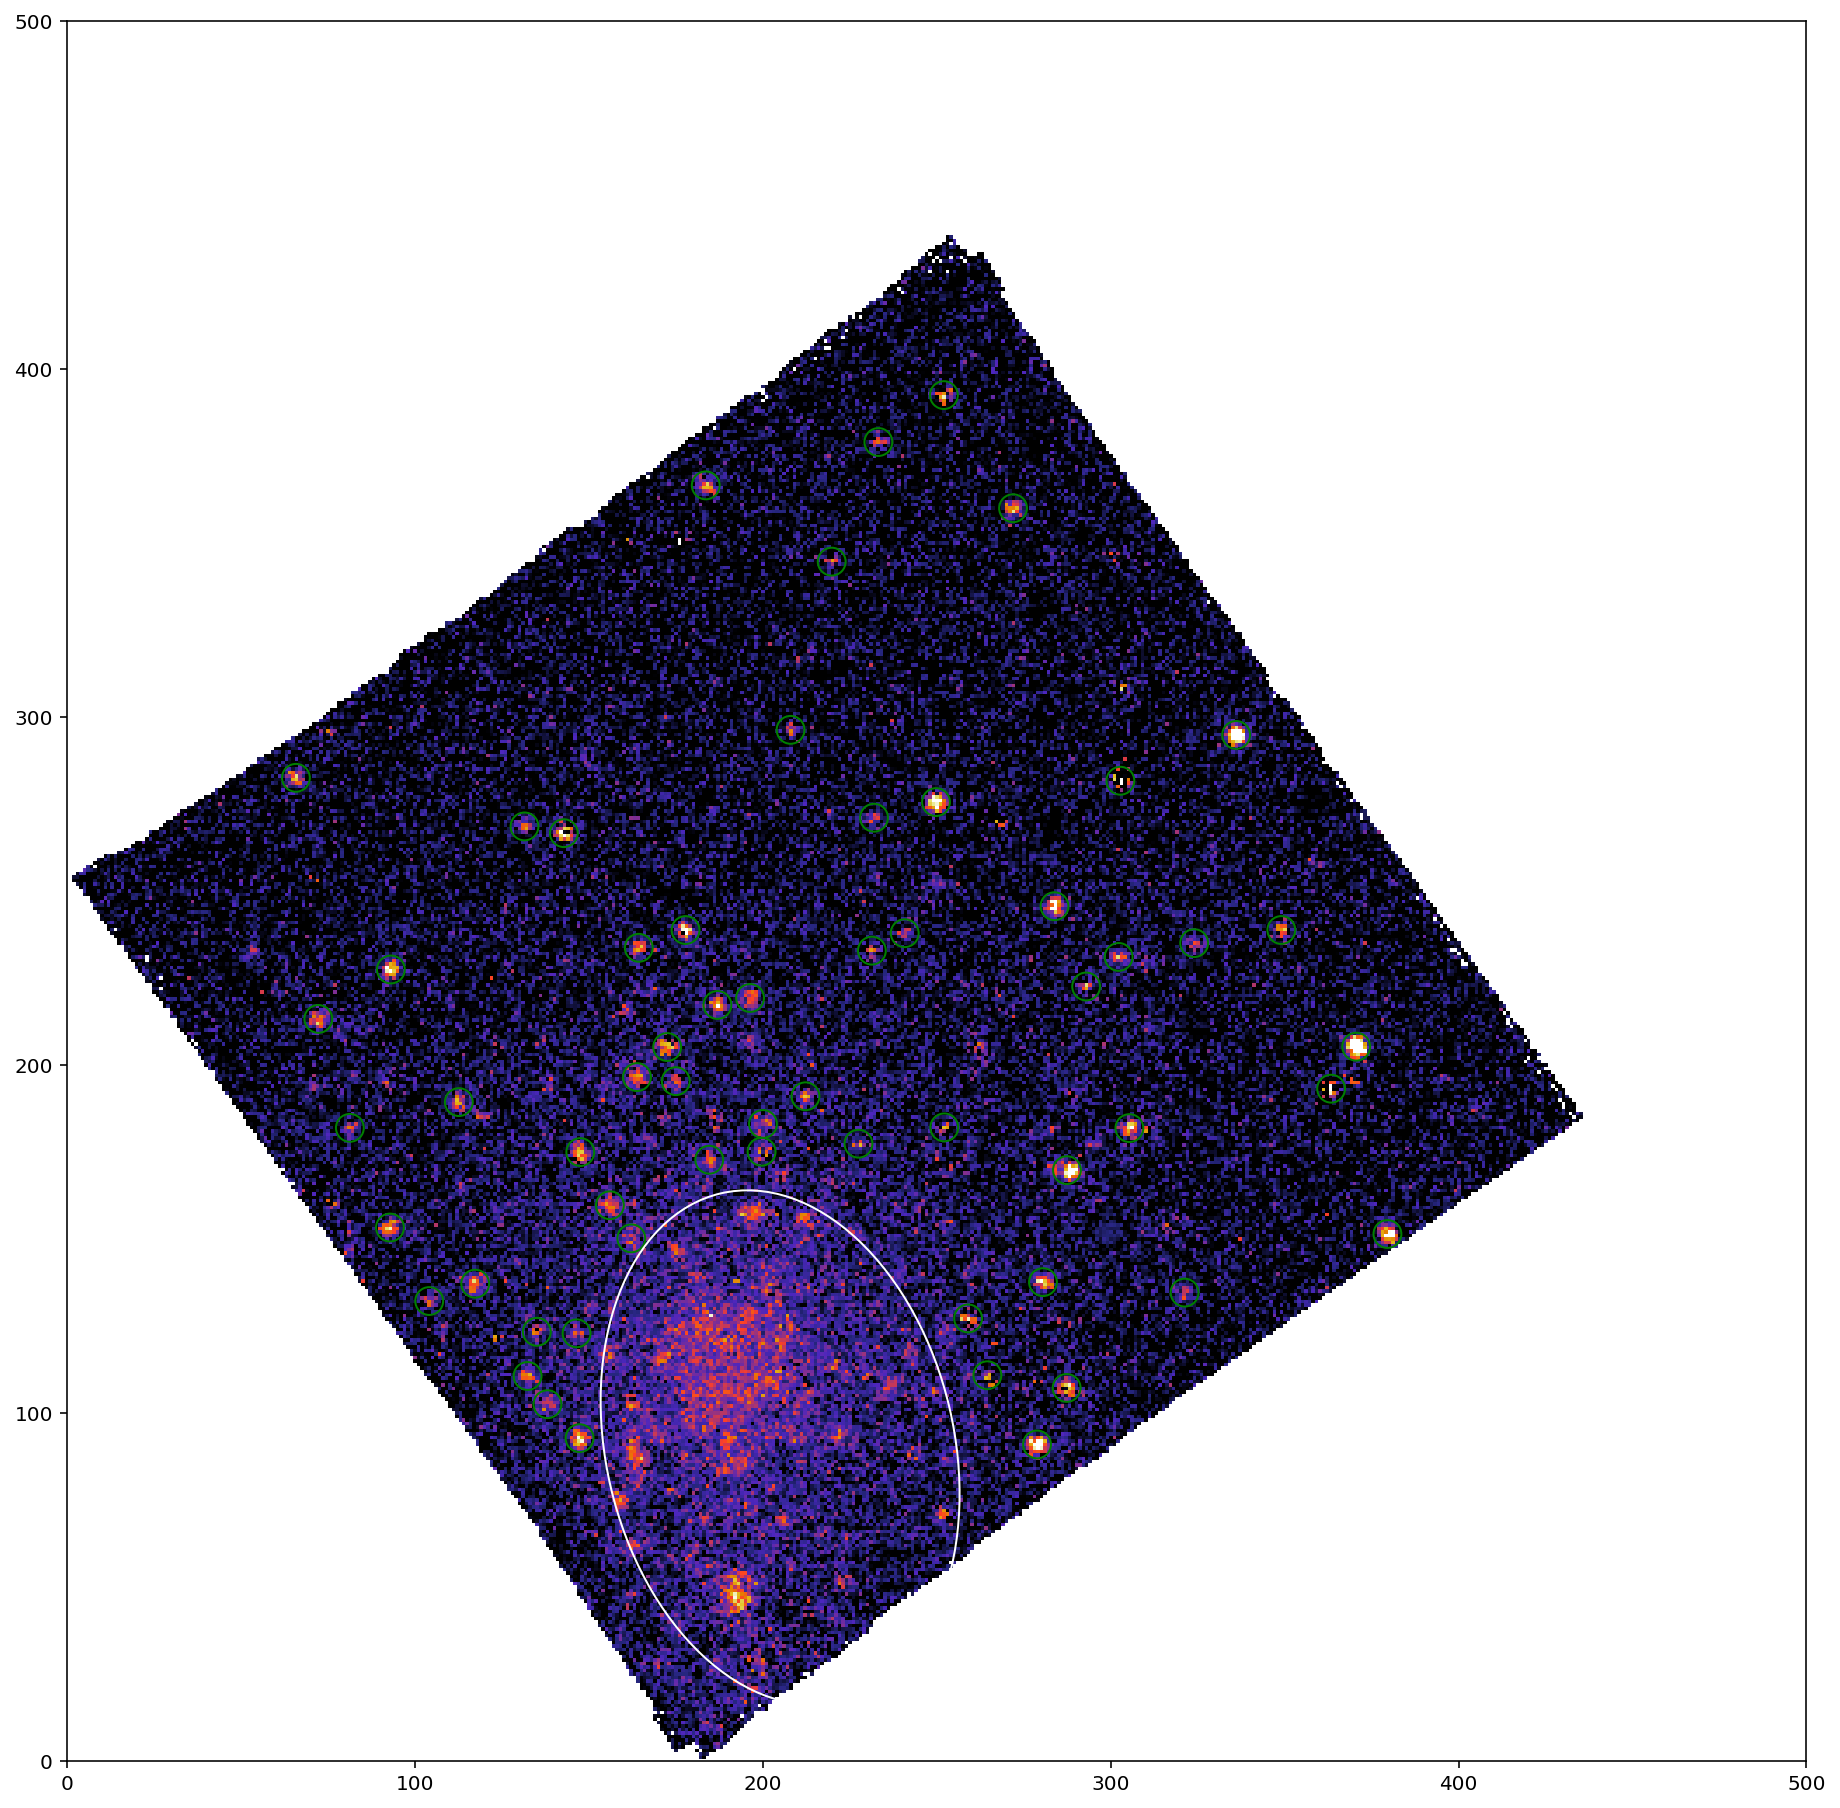

In [14]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]

xe = 205
ye = 90
length= 100
width = 150
alpha = 1.8
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
# xc = 195
# yc = 100
# r = 45
# circ_mask_gal = (X - xc)**2 + (Y-yc)**2 <=r**2

objects = sep.extract(A_rN_plot_shape, 2.8, clean=True, mask=elip_mask_gal)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()

#circ_gal = Circle((xc,yc), r, fill=False, color="white")
#ax.add_artist(circ_gal)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
plt.xlim(0,500)
plt.ylim(0,500)
print(len(x_sep))

#np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

# PSF

In [12]:
PNe_df.nlargest(10, "A/rN")

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D,Chi^2,Include,FWHM,beta,[OIII] Flux
19,19,NaN,NaN,-65.826495,26.532290,-4.826918,NaN,12.051017,NaN,1.040913,NaN,4.0,2.5,7.781867e-17
10,10,NaN,NaN,-14.288554,27.015796,-4.343412,NaN,11.598425,NaN,1.093927,NaN,4.0,2.5,4.985188e-17
23,23,NaN,NaN,-25.552776,27.255052,-4.104156,NaN,11.210024,NaN,1.040086,NaN,4.0,2.5,3.999254e-17


In [31]:
# Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
sel_PNe = PNe_df.nlargest(10, "A/rN").index.values
sel_PNe = [69, 66, 65 ]#, 6,  1, 33, 61, 62]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.01, vary=True )
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001, vary=True)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0, min=0.01, vary=True)
PSF_params.add("beta", value=1.0, vary=True) 

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr /PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr /PSF_results.params["beta"].value)*100) )
print(report_fit(PSF_results))


[69, 66, 65]
FWHM:  4.098527669507977 +/- 0.09535882070731243 (2.33%)
Beta:  2.7122797677276074 +/- 0.4221718938148685 (15.57%)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 192
    # data points      = 45441
    # variables        = 20
    chi-square         = 46313.5057
    reduced chi-square = 1.01964963
    Akaike info crit   = 904.234963
    Bayesian info crit = 1078.71836
[[Variables]]
    moffat_amp_000:  163.053081 +/- 4.02032991 (2.47%) (init = 200)
    x_000:           3.79469766 +/- 0.04663673 (1.23%) (init = 4.5)
    y_000:           4.11953069 +/- 0.04762902 (1.16%) (init = 4.5)
    wave_000:        5039.83425 +/- 0.02809346 (0.00%) (init = 5039.535)
    gauss_bkg_000:   8.6720e-04 +/- 6.1125e-04 (70.49%) (init = 0.01)
    gauss_grad_000: -4.07289716 +/- 3.05550534 (75.02%) (init = 0.001)
    moffat_amp_001:  164.228439 +/- 4.85009652 (2.95%) (init = 200)
    x_001:           4.41896111 +/- 0.05639489 (1.28%) (init = 4.5)
    y_001:          